In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling, random_ising_model

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from scipy.linalg import expm
from qulacs.gate import DenseMatrix, SparseMatrix
from qulacs import QuantumState
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2

import pickle

import sys
sys.path.insert(0, '..') ## insert parent directory in path to access 'parent/gamma_variation' subdirectory

In [87]:
import seaborn as sns; sns.set()
import numpy as np
import pylab as plb

In [3]:
# nspin =10;
# DATA_n10 = {'nspin': nspin, 'experiment' : 'gamma-variation', 'mixer-type' : 'basic' ,
#                  'description': ' convergence data for random ising models of size '+ str(nspin) + ' for different gamma ranges,  ',
#                    'DATA': [] }
# for seed in range(1,11):
#     name= 'gamma_variation/num_spins_' + str(nspin) + '_Gamma_var_num_spins_' + str(nspin) + '_beta_1.5_seed_'+ str(seed) +'.pkl'
#     with open(name,'rb') as f:   dict_mcmc_chains_different_gamma_ranges=pickle.load(f)
#     dic = {'seed': seed, 'mcmc_chains' : dict_mcmc_chains_different_gamma_ranges}
#     DATA_n10['DATA'].append(dic)
# nspin =9;
# DATA_n9 = {'nspin': nspin, 'experiment' : 'gamma-variation', 'mixer-type' : 'basic' ,
#                  'description': ' convergence data for random ising models of size '+ str(nspin) + ' for different gamma ranges,  ',
#                    'DATA': [] }
# for seed in range(1,11):
#     name= 'gamma_variation/num_spins_' + str(nspin) + '_Gamma_var_num_spins_' + str(nspin) + '_beta_1.5_seed_'+ str(seed) +'.pkl'
#     with open(name,'rb') as f:   dict_mcmc_chains_different_gamma_ranges=pickle.load(f)
#     dic = {'seed': seed, 'mcmc_chains' : dict_mcmc_chains_different_gamma_ranges}
#     DATA_n9['DATA'].append(dic)
# nspin =8;
# DATA_n8 = {'nspin': nspin, 'experiment' : 'gamma-variation', 'mixer-type' : 'basic' ,
#                  'description': ' convergence data for random ising models of size '+ str(nspin) + ' for different gamma ranges,  ',
#                    'DATA': [] }
# for seed in range(1,11):
#     name= 'gamma_variation/num_spins_' + str(nspin) + '_Gamma_var_num_spins_' + str(nspin) + '_beta_1.5_seed_'+ str(seed) +'.pkl'
#     with open(name,'rb') as f:   dict_mcmc_chains_different_gamma_ranges=pickle.load(f)
#     dic = {'seed': seed, 'mcmc_chains' : dict_mcmc_chains_different_gamma_ranges}
#     DATA_n8['DATA'].append(dic)
# nspin =11;
# DATA_n11 = {'nspin': nspin, 'experiment' : 'gamma-variation', 'mixer-type' : 'basic' ,
#                  'description': ' convergence data for random ising models of size '+ str(nspin) + ' for different gamma ranges,  ',
#                    'DATA': [] }
# for seed in range(1,11):
#     name= 'gamma_variation/num_spins_' + str(nspin) + '_Gamma_var_num_spins_' + str(nspin) + '_beta_1.5_seed_'+ str(seed) +'.pkl'
#     with open(name,'rb') as f:   dict_mcmc_chains_different_gamma_ranges=pickle.load(f)
#     dic = {'seed': seed, 'mcmc_chains' : dict_mcmc_chains_different_gamma_ranges}
#     DATA_n11['DATA'].append(dic)

# name = 'gamma_variation/DATA_n11.pkl'
# with open(name, 'wb') as f:
#     pickle.dump(DATA_n11, f)


In [88]:
name = 'gamma_variation/DATA_n10.pkl'
with open(name, 'rb') as f:
    DATA_n10 = pickle.load(f)

In [89]:
name = 'gamma_variation/DATA_n8.pkl'
with open(name, 'rb') as f:
    DATA_n8 = pickle.load(f)

In [90]:
GAMMA_RANGES=[(0.01,0.1),(0.11,0.4),(0.41,0.7),(0.75,0.95)] ; BETA = 1.50
def recast_data(dataset: dict, nspin: int, to_observe= {'acceptance_prob', 'hamming'}):

    gamma_rangewise_data = {}
    for gr in list(dataset['DATA'][0]['mcmc_chains'].keys()) :
        gamma_rangewise_data[gr] = []
        
    for exp in dataset['DATA'] :

        model = random_ising_model(n_spins= nspin, seed= exp['seed'])
        exact_sampled_model = Exact_Sampling(model, BETA)

        for key, value in exp['mcmc_chains'].items() :
            gamma_rangewise_data[key].append(get_trajectory_statistics(value, exact_sampled_model, to_observe= to_observe))

    gamma_rangewise_data_new = {}
    for key in  gamma_rangewise_data.keys() :
        
        data = {i : { 'y_data': []} for i in to_observe}    
        
        for experiments in gamma_rangewise_data[key] :

            bins_acceptance_prob = np.linspace(0,1,20)
            y, bins_ = np.histogram(experiments['acceptance_prob'], bins_acceptance_prob) 
            data['acceptance_prob']['y_data'].append(y) 

            # y, bins = np.histogram(experiments['hamming'], np.linspace(0,nspin, nspin +1))
            # data['hamming'].append(y)
        
        data['acceptance_prob']['bin_data'] = bins_acceptance_prob
        
        gamma_rangewise_data[key] = data
        
    return gamma_rangewise_data

        
        
    

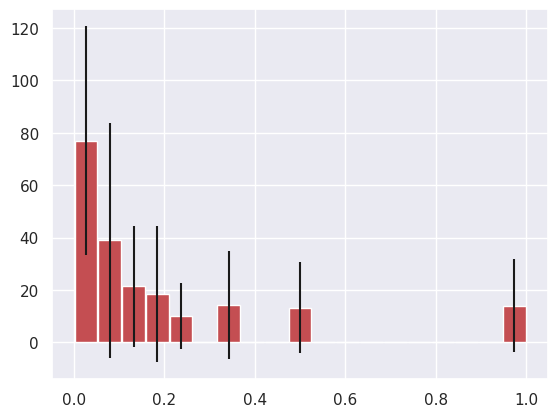

In [91]:
d = recast_data(DATA_n10, 10)
df = pd.DataFrame(d['gamma_range=(0.01, 0.1)']['acceptance_prob']['y_data'])

y,binEdges =  df.mean(), d['gamma_range=(0.01, 0.1)']['acceptance_prob']['bin_data']
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = df.std()
width      = 0.05

plb.bar(bincenters, y, width=width, color='r', yerr=menStd)
# plb.xscale('log')
plb.show()

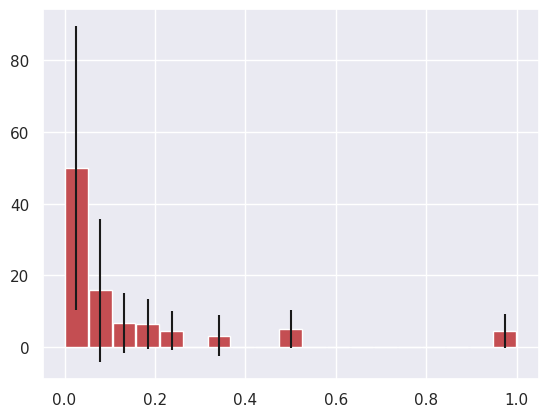

In [92]:
d = recast_data(DATA_n8, 8)
df = pd.DataFrame(d['gamma_range=(0.01, 0.1)']['acceptance_prob']['y_data'])

y,binEdges =  df.mean(), d['gamma_range=(0.01, 0.1)']['acceptance_prob']['bin_data']
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = df.std()
width      = 0.05

plb.bar(bincenters, y, width=width, color='r', yerr=menStd)
# plb.xscale('log')
plb.show()

In [56]:
# ###dict mcmc statistics
# dict_mcmc_statistics={}
# for i in range(0,len(list_range_gamma)):
#     print(f"gamma range: {list_range_gamma[i]}")
#     mcmc_chain=dict_mcmc_chains_different_gamma_ranges[f"gamma_range={list_range_gamma[i]}"]
#     statistics=get_trajectory_statistics(mcmc_chain,exact_sampled_model,verbose=False)
#     dict_mcmc_statistics[f"gamma_range={list_range_gamma[i]}"]=statistics
# #dict_mcmc_statistics.keys()

# #
# # ### acceptance probability plot
# plt.figure(figsize=(10,10))

# #plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.8, bins= 20)
# for i in tqdm(range(0, len(list_range_gamma))):
#     mcmc_statistics=dict_mcmc_statistics[f"gamma_range={list_range_gamma[i]}"]
#     plt.hist(np.log10(mcmc_statistics["acceptance_prob"]),
#          label= r'$\gamma \in$'+str(list_range_gamma[i]), 
#          alpha= 0.4, bins= 50)
# # plt.xscale("log")
# plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.title(f"num_spins={n_spins}, number of iterations=10k")
# plt.legend()
# plt.show()

# plt.figure(2,figsize=(10,12))
# for i in tqdm(range(0,len(list_range_gamma))):
#     mcmc_statistics=dict_mcmc_statistics[f"gamma_range={list_range_gamma[i]}"]
#     plt.subplot(2,2,i+1)
#     plt.hist(np.log10(mcmc_statistics["acceptance_prob"]),
#          label= r'$\gamma \in$'+str(list_range_gamma[i]), 
#          alpha= 0.6, bins= 50)
#     plt.legend()
# plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.suptitle(f"Acceptance Probabilities num_spins={n_spins}, number of iterations=10k")
# plt.show()

# #
# ### hamming distance plot
# plt.figure(3,figsize=(8,8))
# for i in tqdm(range(0,len(list_range_gamma))):
#     mcmc_statistics=dict_mcmc_statistics[f'gamma_range={list_range_gamma[i]}']
#     list_hamming_dist_accepted=[mcmc_statistics['hamming'][k]['accepted']/mcmc_statistics['hamming'][k]['total'] 
#                                 if mcmc_statistics['hamming'][k]['total']!=0 else 0 for k in range(0,n_spins+1) ]
#     list_hamming_dist_rejected=[mcmc_statistics['hamming'][k]['rejected']/mcmc_statistics['hamming'][k]['total'] 
#                                 if mcmc_statistics['hamming'][k]['total']!=0 else 0 for k in range(0,n_spins+1) ]
#     #list_hamming_dist_total=[mcmc_statistics['hamming'][k]['total'] for k in range(0,n_spins+1)]
#     plt.subplot(2,2,i+1)
#     plt.stem(list(mcmc_statistics['hamming'].keys()),list_hamming_dist_accepted,'b',label=r'$\frac{accepted}{proposed}$')
#     plt.stem(list(mcmc_statistics['hamming'].keys()),list_hamming_dist_rejected,'g',markerfmt="X",label=r'$\frac{rejected}{proposed}$')
#     #plt.stem(list(mcmc_statistics['hamming'].keys()),list_hamming_dist_total,'k',markerfmt="x",label='no. of proposals')
#     plt.title(r'$\gamma \in $'+str(list_range_gamma[i]))
#     plt.yscale('log')
# plt.legend(bbox_to_anchor=(1.75,1.3),fontsize=20)
# plt.suptitle(f'Hamming distance plot: num spins={n_spins}, beta={beta}, no. of iterations={10}k')


# ########################################

gamma range: (0.01, 0.1)


ValueError: shapes (8,8) and (10,) not aligned: 8 (dim 1) != 10 (dim 0)